In [30]:
from scipy import misc
import numpy as np
from scipy.fftpack import dct, idct
from skimage.color import rgb2lab, lab2rgb
import math
import matplotlib.pyplot as plt
from quant_tables import *
import utils
import JPEG
import bitarray
import gzip
import os
%matplotlib inline


In [13]:
calBlue = misc.imread('images/calBlue.tiff')
Marconi = misc.imread('images/Marconi.tiff')
createrLake = misc.imread('images/createrLake.tiff')
Isee = misc.imread('images/Isee.tiff')
pauly = misc.imread('images/pauly.tiff')

In [14]:
def zeropad_image(V):
    def roundup(x):
        return int(math.ceil(x * 1.0 / 8)) * 8
    rows, cols = roundup(V.shape[0]), roundup(V.shape[1])
    zeros = np.zeros((rows, cols, 3), dtype='uint8')
    zeros[:V.shape[0], :V.shape[1], :] = V
    return zeros

In [15]:
#Zero_pad
O = zeropad_image(calBlue)
#Conver to YCbCr
O = rgb2lab(O)
#Add offset
O[:,:,[1,2]] += 128

In [16]:
def block_image(V):
    l = []
    for i in np.arange(0,V.shape[0], 8):
        for j in np.arange(0, V.shape[1], 8):
            l.append(V[i:i+8, j:j+8, :])
    return np.array(l)

def dct_2d(X):
    return dct(dct(X, axis=1,norm="ortho"), axis=2,norm="ortho")

def dct_all(X):
    blocks = block_image(X)
    return dct_2d(blocks)

def idct_2d(X):
    return idct(idct(X, axis=1,norm="ortho"), axis=2,norm="ortho")

#Blocks and applies DCT
blocked_image = block_image(O)
O_dct = dct_2d(blocked_image)

In [17]:
def quantize(DCT_coeffs, q):
    DCT_coeffs = DCT_coeffs.copy()
    def a(q):
        assert q in range(1,101)
        if q in range(1, 51):
            return 50.0/q
        else:
            return 2-q*1.0/50
    alpha = a(q)
    
    DCT_coeffs[:,:,:,0] = np.round(DCT_coeffs[:,:,:,0]*1.0/(alpha*luminance_table))
    DCT_coeffs[:,:,:,1] = np.round(DCT_coeffs[:,:,:,1]*1.0/(alpha*chrominance_table))
    DCT_coeffs[:,:,:,2] = np.round(DCT_coeffs[:,:,:,2]*1.0/(alpha*chrominance_table))
    
    return DCT_coeffs

O_q = quantize(dct_all(O),50)

In [7]:
def zigzag_blocks(img):
    """
    shape is Mx8x8xC
    where M is number of 8x8 dft blocks
    """
    num_blocks = img.shape[0]
    nz = img.shape[3]
    vector = np.empty(img.shape[0] * img.shape[1] * img.shape[2] * img.shape[3])
    indexorder = sorted(((y, x) for y in xrange(8) for x in xrange(8)), \
        key = lambda (y,x): (y+x, -x if (y+x) % 2 else x) )
    counter = 0
    for i, idx in enumerate(indexorder):
        y, x = idx
        for j in xrange(img.shape[0]):
            vector[3*counter:3*counter+3] = img[j, y, x, :]
            counter += 1
    return vector

def zigzag_decode(vec, height, width, channels=3):
    rdup = lambda x: int(math.ceil(x * 1.0 / 8)) * 8
    r_height = rdup(height)
    r_width = rdup(width)
    ny = r_height/8
    nx = r_width/8
    num_blocks = r_height * r_width / 64
    img = np.empty((num_blocks,8,8,channels))
    indexorder = sorted(((y, x) for y in xrange(8) for x in xrange(8)), \
        key = lambda (y,x): (y+x, -x if (y+x) % 2 else x) )
    counter = 0
    for i, idx in enumerate(indexorder):
        y, x = idx
        for j in xrange(img.shape[0]):
            img[j, y, x, :] = vec[3*counter:3*counter+3]
            counter += 1
    return img

#test = np.arange(384).reshape(24,16,1)
#print test
#vector = zigzag_full(test)
#print vector
#print vector
#np.savetxt('test.gz', vector)
#np.savetxt('test', vector)

def gzip_compress(filename, vector):
    """
    file extension must have '.gz' to use gzip compression
    """
    np.savetxt(filename, vector)

In [8]:
def JPEG_compression(image, quality = 50):
    """
    
    Takes in an RGB image and applys the JPEG compression algorithm
    Steps:
    -Preprocessing
    -DCT
    -Quantinization
    
    Input:
    quality- determines the amount of lossy compression 
    
    Output:
    Numpy array of 8x8 blocks for each channel
    [number of blocks, 8,8,3]
    """
    #Prepocessing
    im = zeropad_image(image)
    im = rgb2lab(im)
    im[:,:,[1,2]] += 128
    #Blocked into 8x8 blocks and apply DCT
    im_dct = dct_all(im)
    #Quantize
    im_q = quantize(im_dct,quality)
    im_vec = zigzag_blocks(im_q)
    return im_vec.astype(np.int16)
    #return im_vec

In [9]:
data = JPEG_compression(calBlue,50)

In [10]:
def idct_2d(X):
    return idct(idct(X, axis=1,norm="ortho"), axis=2,norm="ortho")

def unblock_image(X,height, width):
    def roundup(x):
        return int(math.ceil(x * 1.0 / 8)) * 8
    height, width = roundup(height), roundup(width)
    result = np.zeros((height,width,3))
    n = 0
    for i in np.arange(0,height, 8):
        for j in np.arange(0, width, 8):
            result[i:i+8,j:j+8,:] = X[n]
            n += 1
    return result
    
def unquantize(X,q):
    X = X.copy()
    def a(q):
        assert q in range(1,101)
        if q in range(1, 51):
            return 50.0/q
        else:
            return 2-q*1.0/50
    alpha = a(q)
    
    X[:,:,:,0] = np.round(X[:,:,:,0]*(alpha*luminance_table))
    X[:,:,:,1] = np.round(X[:,:,:,1]*(alpha*chrominance_table))
    X[:,:,:,2] = np.round(X[:,:,:,2]*(alpha*chrominance_table))
    
    return X


In [11]:
def JPEG_decompression(data, quality, height, width, channels=3):
    data = zigzag_decode(data, height, width, channels)
    im_q = unquantize(data,quality)
    #IDCT
    im_idct = idct_2d(im_q)
    #Unblock
    im = unblock_image(im_idct,height,width)
    
    #Undo offset and return to RGB
    im[:,:,[1,2]] -= 128
    im = lab2rgb(im) * 255 # lab2rgb converts to float64
    return im[0:height,0:width].astype(np.uint8)

In [12]:
quality = 50
image = createrLake

quality = 1
data = JPEG_compression(image,quality)
im1 = JPEG_decompression(data,quality,image.shape[0],image.shape[1])

quality = 10
data = JPEG_compression(image,quality)
im10 = JPEG_decompression(data,quality,image.shape[0],image.shape[1])

quality = 50
data = JPEG_compression(image,quality)
im50 = JPEG_decompression(data,quality,image.shape[0],image.shape[1])

print psnr(image, im1)
print psnr(image, im10)
print psnr(image, im50)

11.1366247769
24.0130936502
30.3636624177


In [13]:
print(utils.psnr(im,image))

30.3636624177


In [14]:
with gzip.open('file.gz', 'wb') as f:
    f.write(data)

In [15]:
with gzip.open('file2.gz', 'wb') as f:
    f.write(image)

In [17]:
print(utils.get_file_size('file.gz'))
print(utils.get_file_size('file2.gz'))
print(utils.get_file_size('images/Marconi.tiff'))

65781
1135883
2400946


In [ ]:
with gzip.open('file.gz', 'rb') as f:
    file_content = f.read()

In [ ]:
plt.imshow(image);plt.show()
plt.imshow(im)

In [26]:
qs = range(1,99,5)
image = Marconi
psnrs = []
sizes = []
for quality in qs:
    data = JPEG_compression(image,quality)
    im = JPEG_decompression(data,quality,image.shape[0],image.shape[1])
    psnrs.append(utils.psnr(image,im))
    utils.save_to_gzip(data,"file")
    sizes.append(utils.get_file_size('file.gz'))


/home/lev/anaconda3/envs/py27/lib/python2.7/site-packages/skimage/color/colorconv.py:901: UserWarning: Color data out of range: Z < 0 in 20 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/home/lev/anaconda3/envs/py27/lib/python2.7/site-packages/skimage/color/colorconv.py:901: UserWarning: Color data out of range: Z < 0 in 18 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/home/lev/anaconda3/envs/py27/lib/python2.7/site-packages/skimage/color/colorconv.py:901: UserWarning: Color data out of range: Z < 0 in 7 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)
/home/lev/anaconda3/envs/py27/lib/python2.7/site-packages/skimage/color/colorconv.py:901: UserWarning: Color data out of range: Z < 0 in 2 pixels
  warn('Color data out of range: Z < 0 in %s pixels' % invalid[0].size)


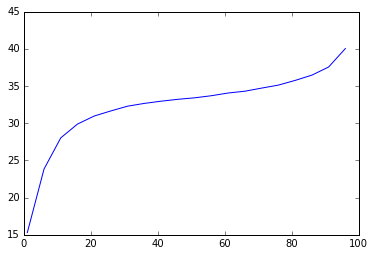

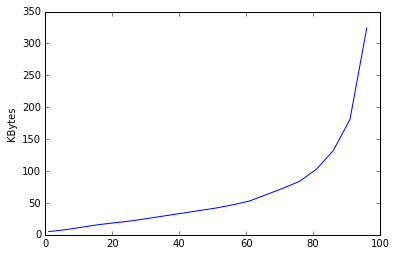

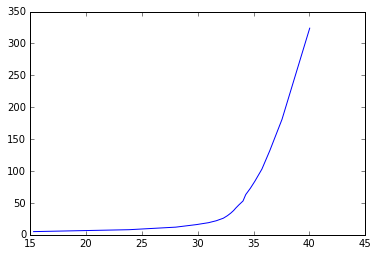

In [27]:
plt.plot(qs,psnrs)
plt.xlabel("quality")
plt.ylabel("KBytes")
plt.figure()
plt.plot(qs,np.array(sizes)/1000)
plt.ylabel("KBytes")
plt.figure()
plt.plot(psnrs,np.array(sizes)/1000)